In [125]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_auc_score
from sklearn.linear_model import LassoCV,ridge,ElasticNetCV,ElasticNetCV
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import sequential_feature_selector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
from warnings import filterwarnings
filterwarnings('ignore')

In [12]:
df=pd.read_csv('Telecom_industry.csv')

In [13]:
df.shape

(3333, 11)

In [14]:
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3331 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [198]:
df[['Churn','ContractRenewal','DataPlan']]=df[['Churn','ContractRenewal','DataPlan']].astype('object')

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3331 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3331 non-null   object 
 1   AccountWeeks     3331 non-null   int64  
 2   ContractRenewal  3331 non-null   object 
 3   DataPlan         3331 non-null   object 
 4   DataUsage        3331 non-null   float64
 5   CustServCalls    3331 non-null   int64  
 6   DayMins          3331 non-null   float64
 7   DayCalls         3331 non-null   int64  
 8   MonthlyCharge    3331 non-null   float64
 9   OverageFee       3331 non-null   float64
 10  RoamMins         3331 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 312.3+ KB


In [202]:
print("categorical features:\n",list(df.select_dtypes(include=['object']).columns))
print('-'*50)
print('Numerical features:\n',list(df.select_dtypes(exclude=['object']).columns))

categorical features:
 ['Churn', 'ContractRenewal', 'DataPlan']
--------------------------------------------------
Numerical features:
 ['AccountWeeks', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins']


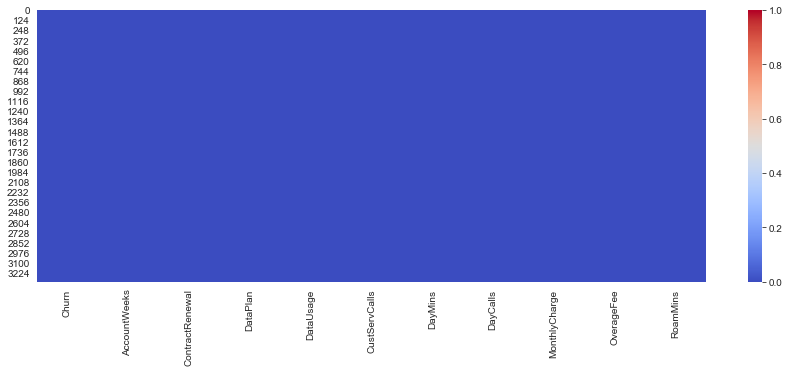

In [39]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,5)
sns.heatmap(df.isnull(),cmap='coolwarm')
plt.show()

- there are no missing values in the dataset

In [74]:
#df['RoamMins']=df['RoamMins'].replace('NaN',np.nan)
df.dropna(inplace=True)

In [18]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

- we can see that the target labels are inbalanced and hence needs to be balanced to improve the accuracy of the model in the later stages of the analysis

### Exploratory Data Analysis

- since the datatypes of most of the variables are numerical thers no need of encoding the obervations

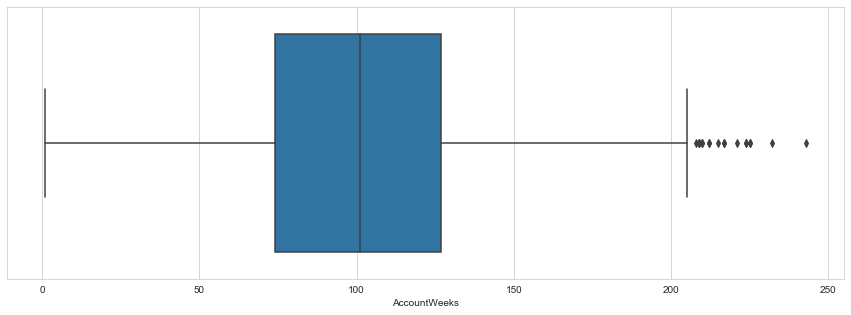

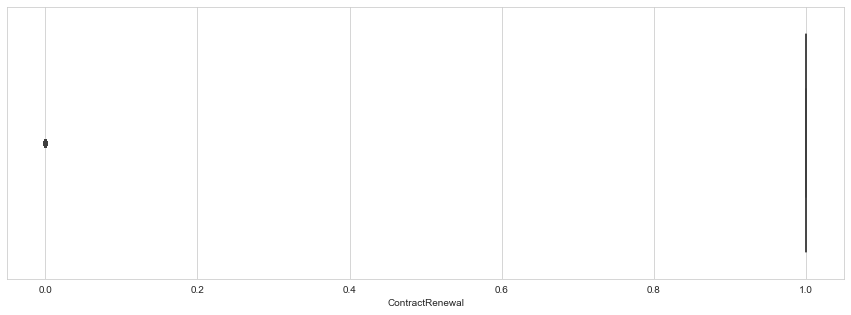

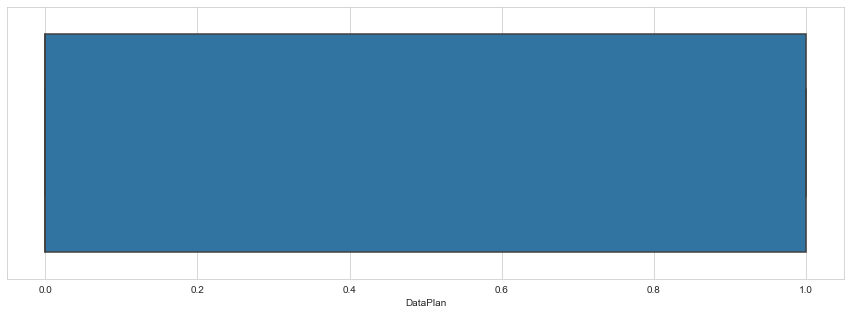

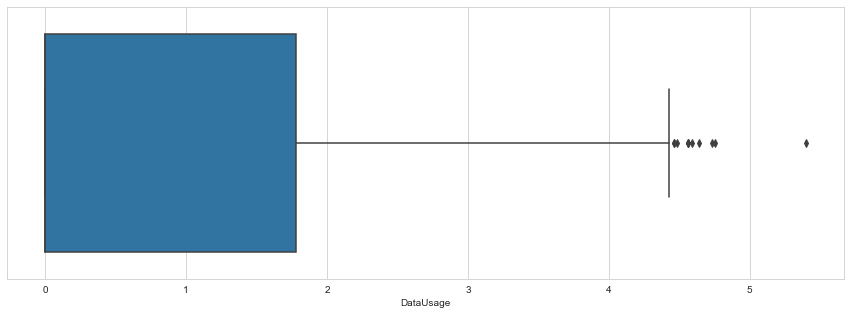

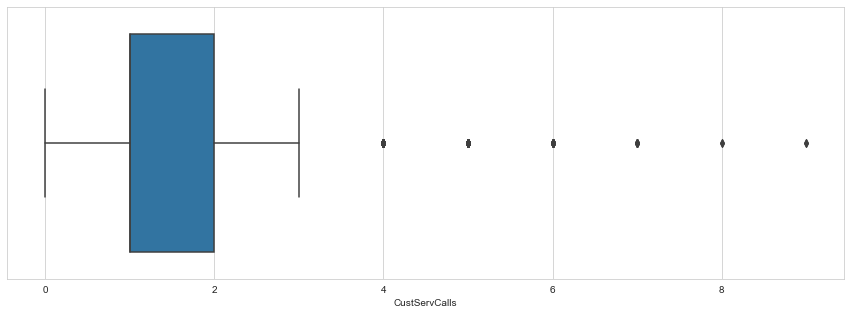

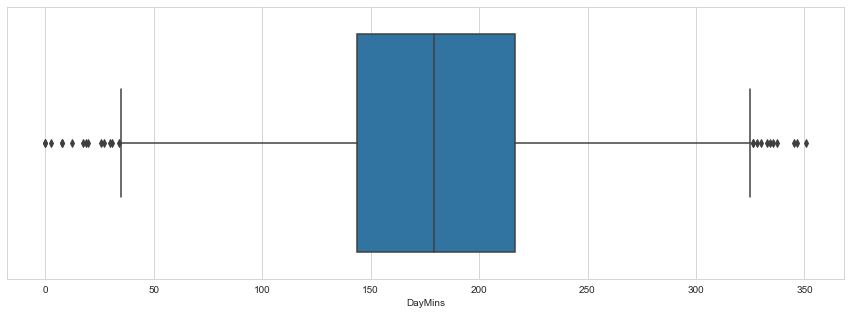

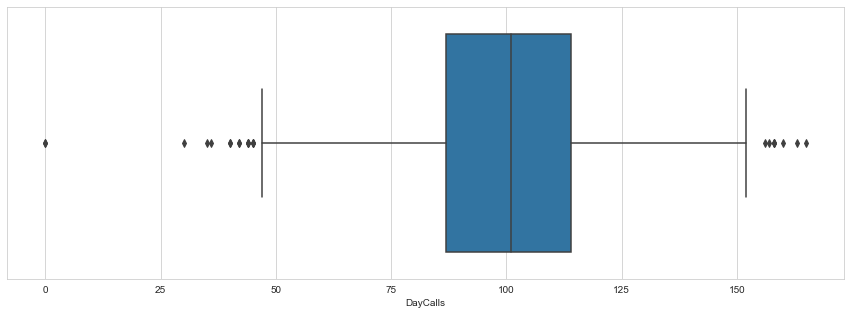

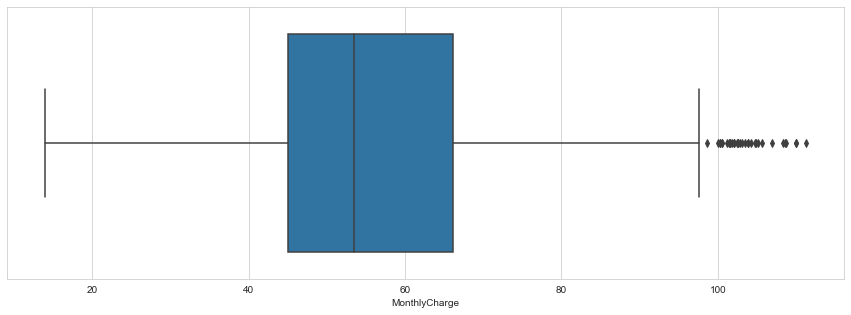

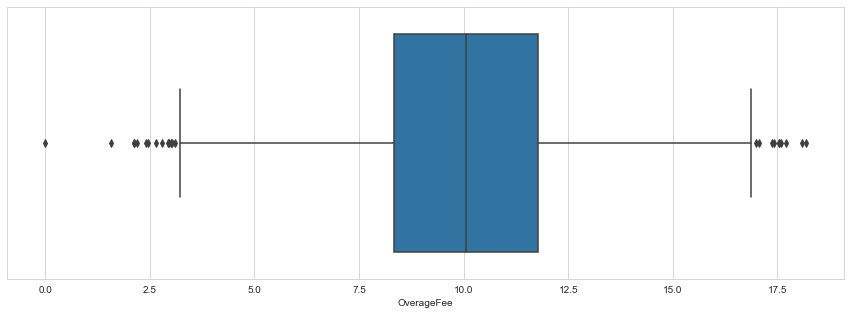

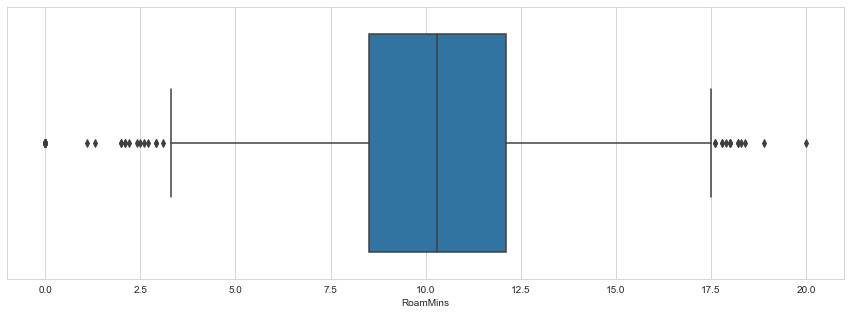

In [40]:
#lets check if thers any outliers in the dataset
for col in df.columns.tolist()[1:]:
    sns.boxplot(df[col])
    plt.show()

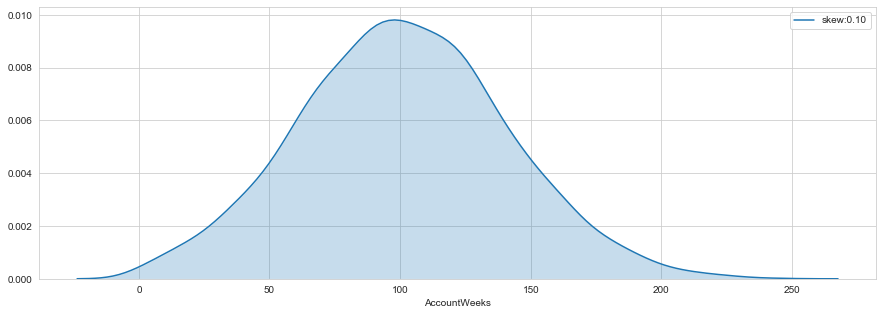

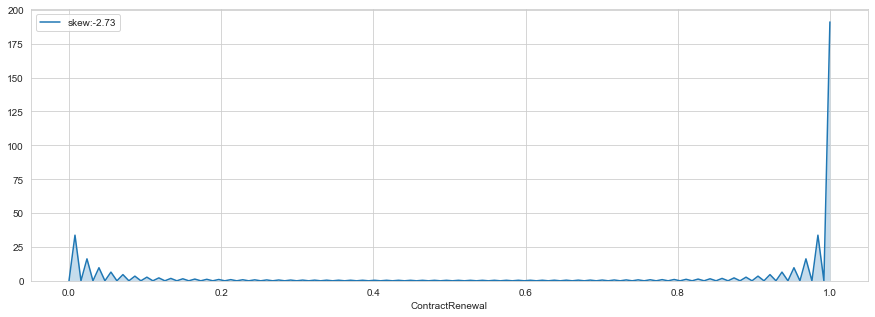

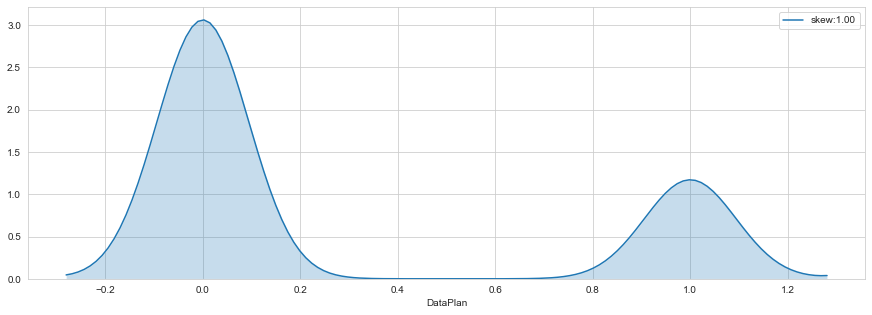

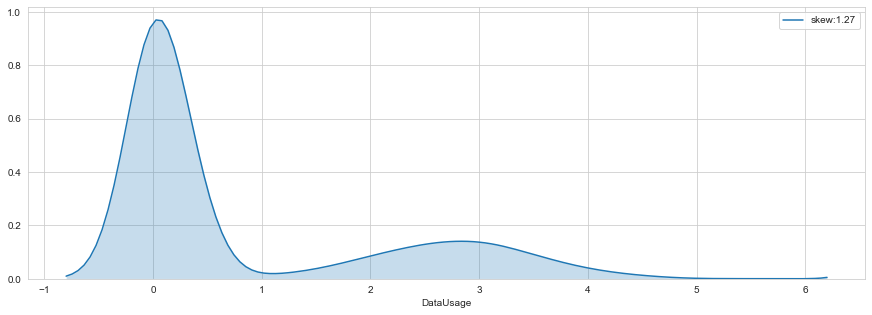

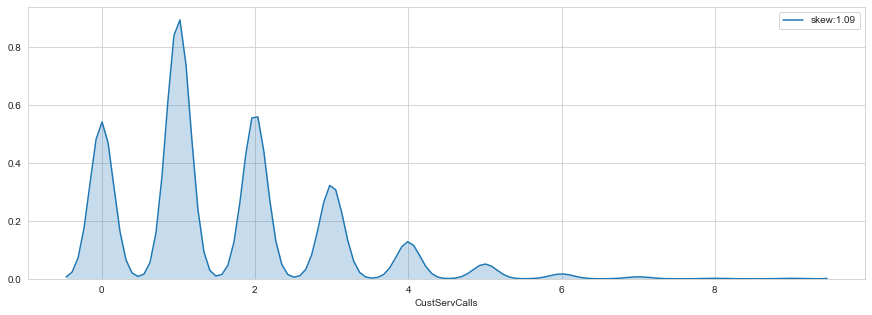

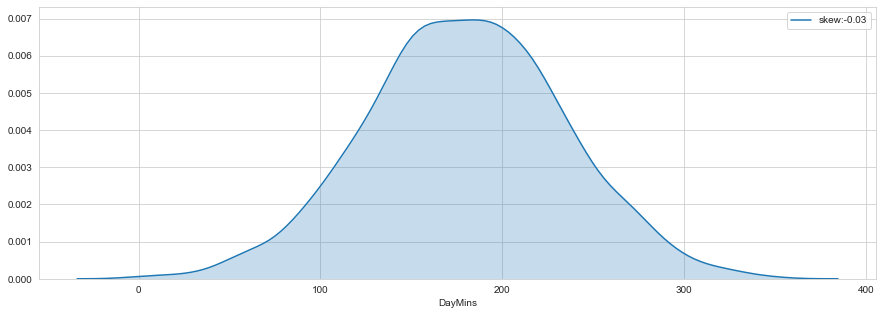

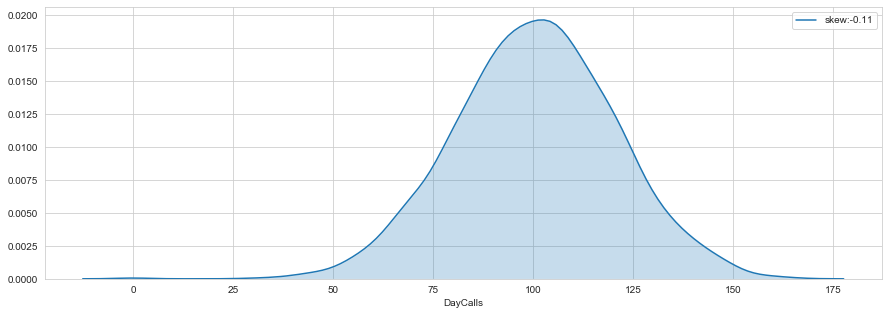

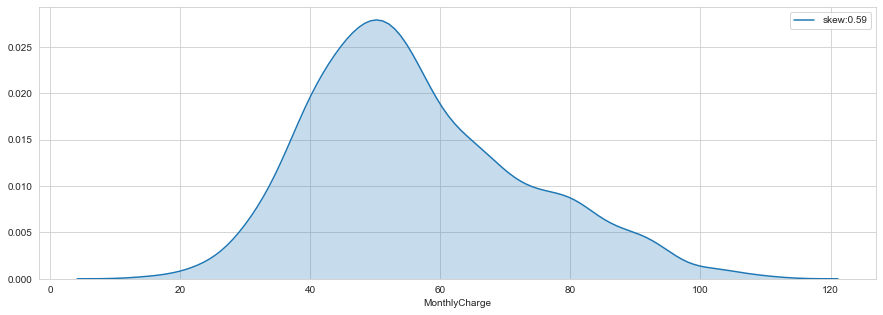

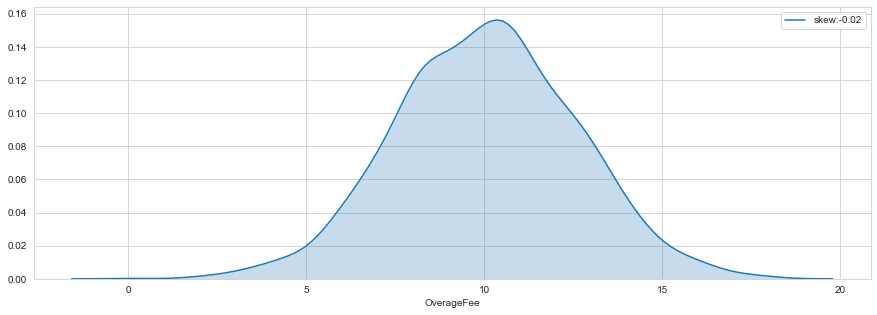

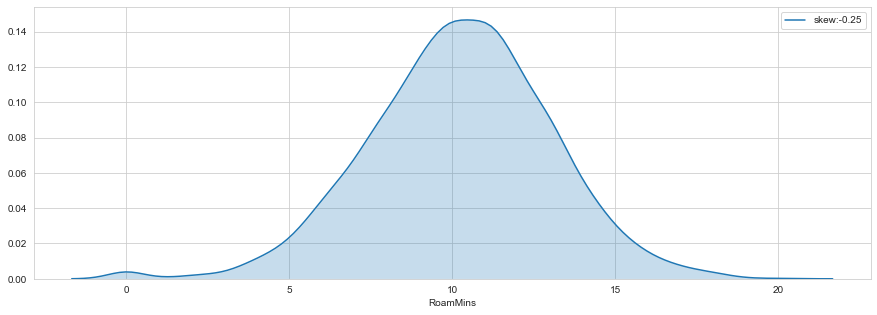

In [43]:
#lets check the distribution of the data
for col in df.columns.tolist()[1:]:
    skew=df[col].skew()
    sns.distplot(df[col],hist=False,label='skew:%1.2f'%(skew),kde_kws={'shade':True})
    plt.legend(loc='best')
    plt.show()

- we can see that the conatact renewal and data usage are highly skewed when compared to the rest of the features in the dataset

### Lets do some bivariate Analysis on the data

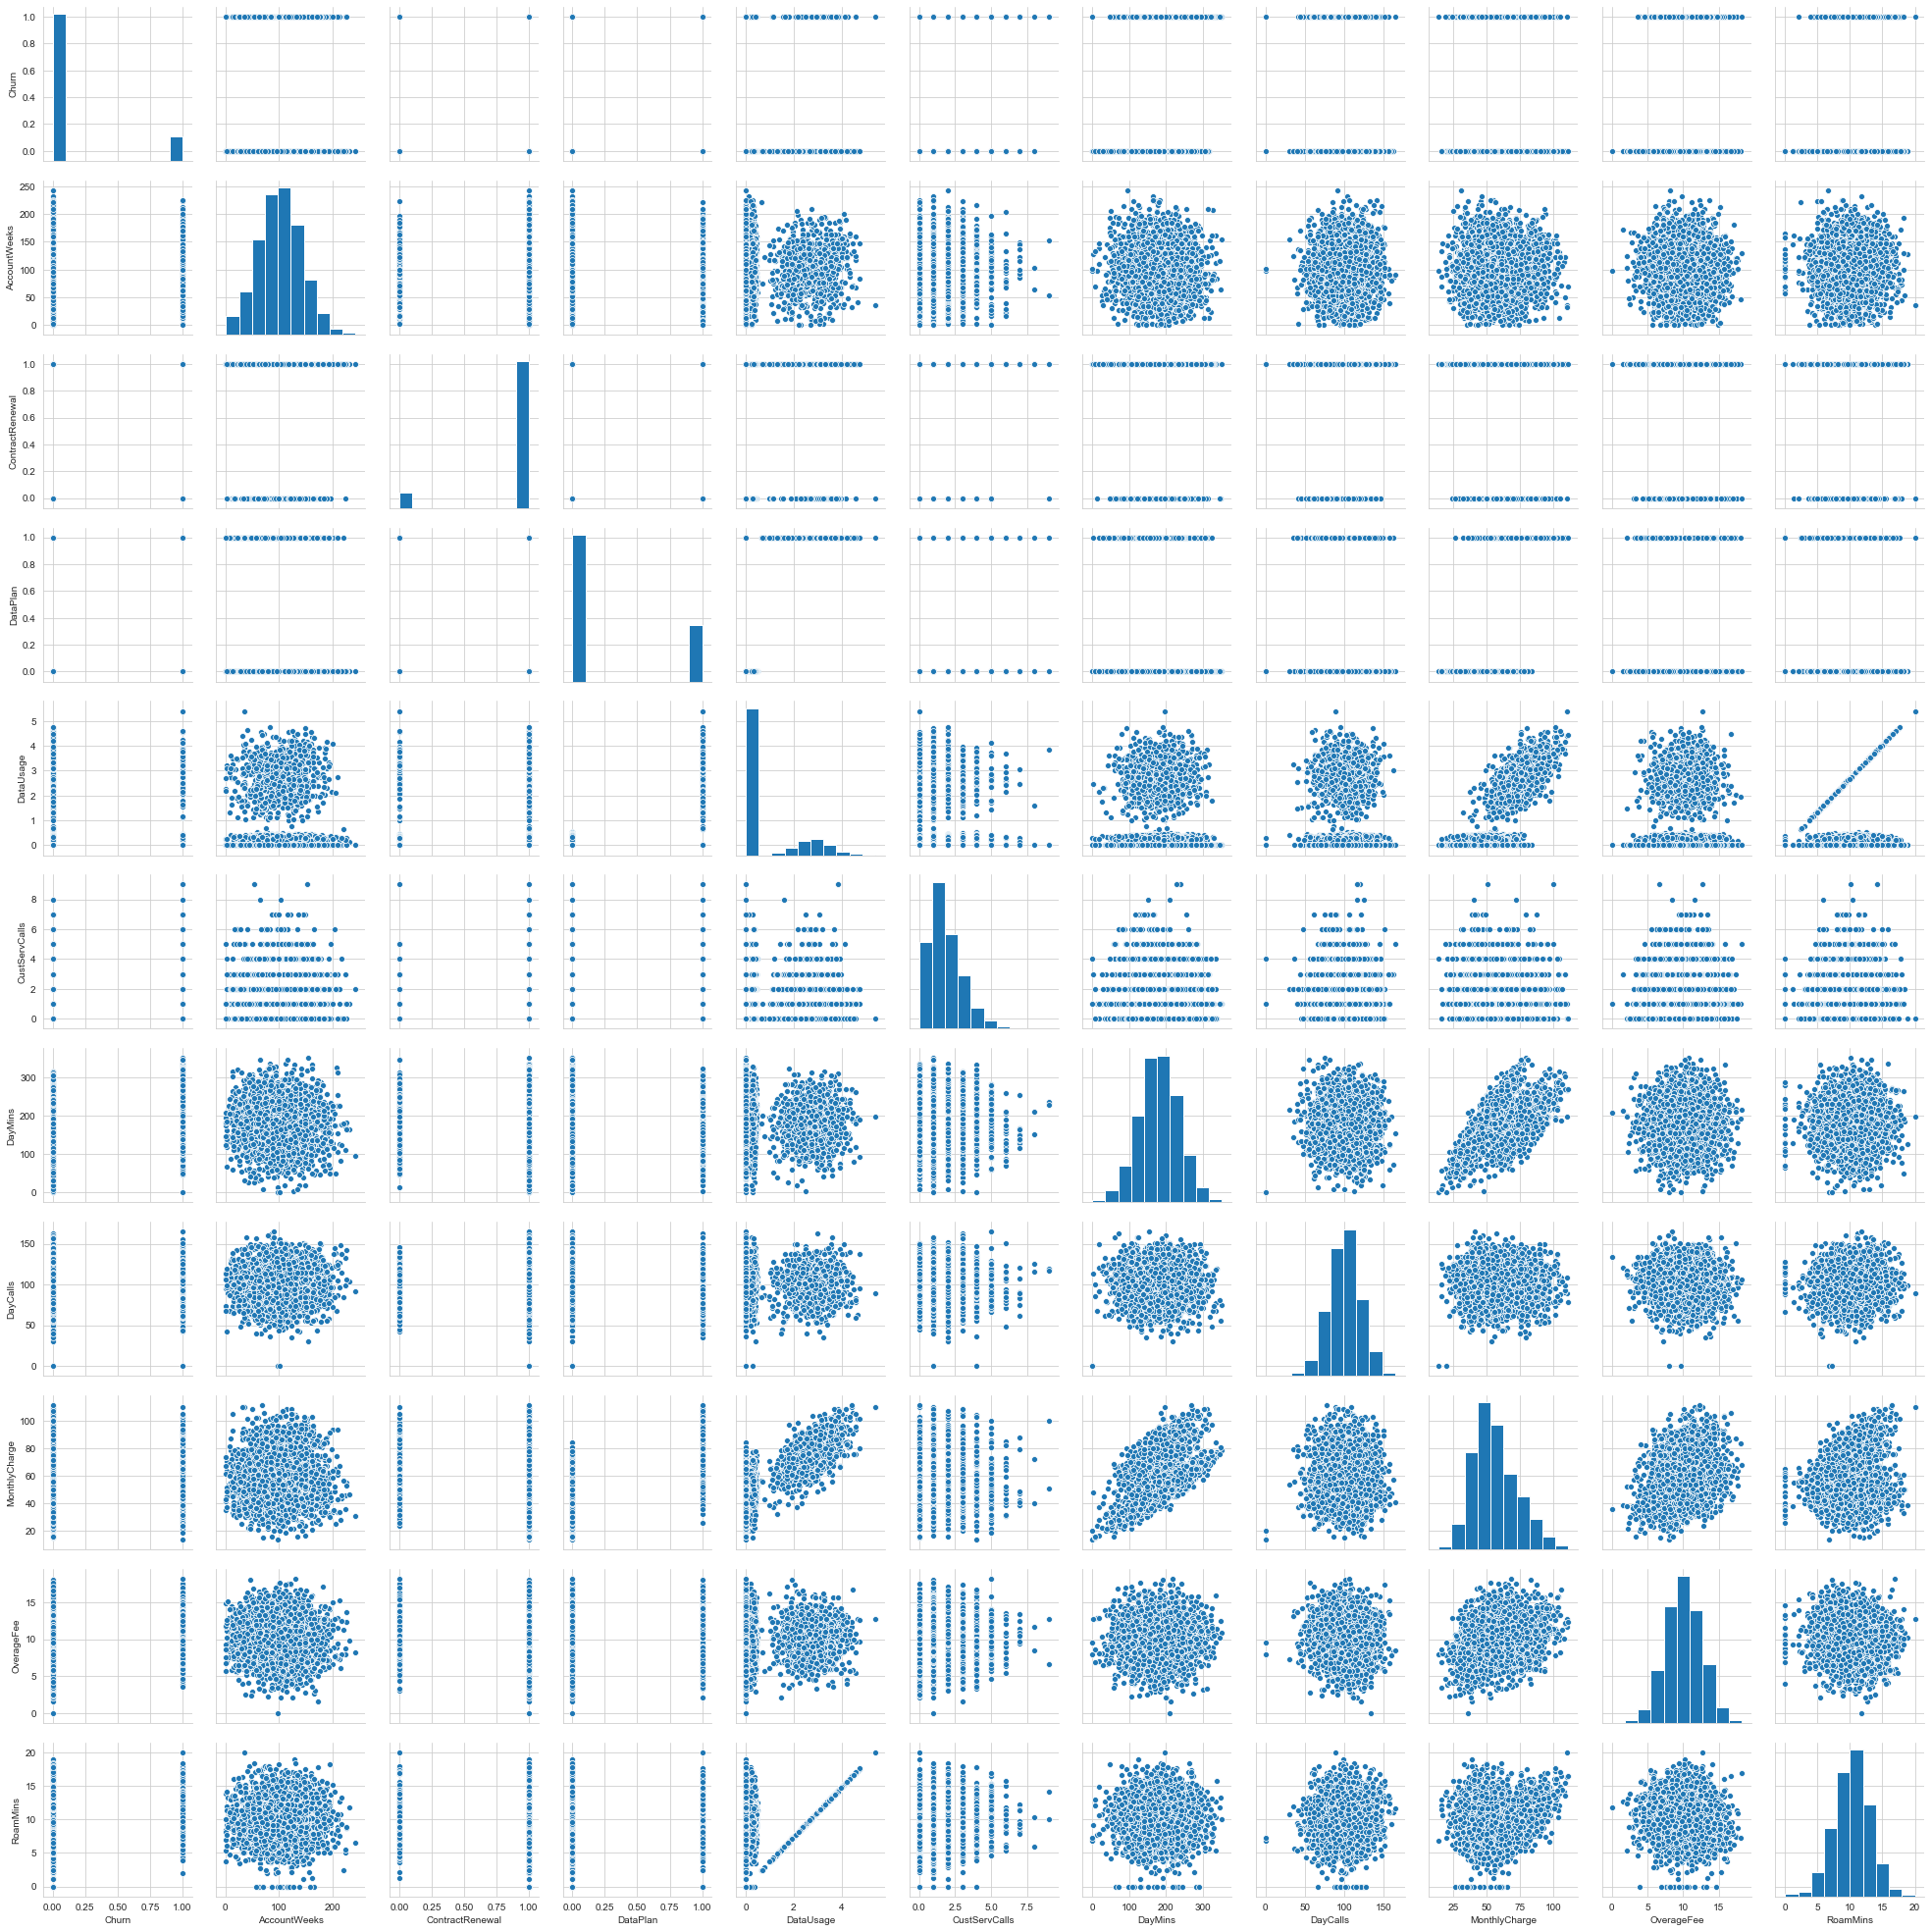

In [31]:
sns.pairplot(df)
plt.show()

- we can see that the most of the features are normally distributed and the none of them have linear relationship with the target variable that is churn

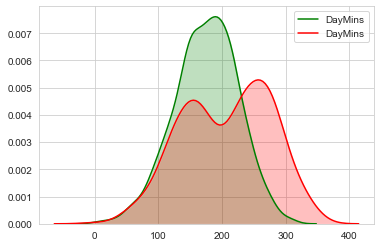

In [36]:
daymin_0=df[df['Churn']==0]['DayMins']
daymin_1=df[df['Churn']==1]['DayMins']
sns.kdeplot(daymin_0,color='g',shade=True)
sns.kdeplot(daymin_1,color='r',shade=True)
plt.show()

- we can see that the non churned data is in the range of the 100-200 mins most of the time and where as non churned data is concerned the the time ranges from 100-400 mins per day where 400 mins being the highest.

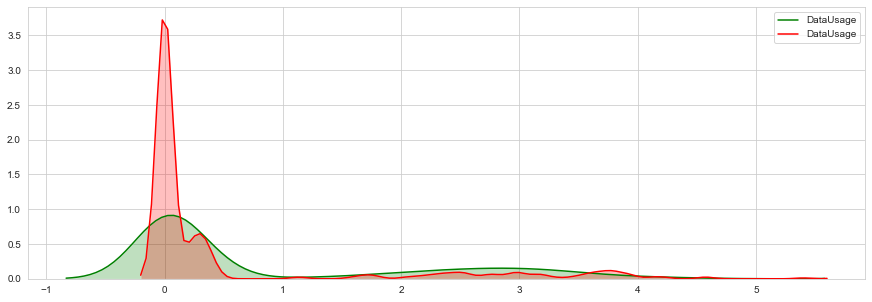

In [42]:
daymin_0=df[df['Churn']==0]['DataUsage']
daymin_1=df[df['Churn']==1]['DataUsage']
sns.kdeplot(daymin_0,color='g',shade=True)
sns.kdeplot(daymin_1,color='r',shade=True)
plt.show()

- we can see that the data usage is more in the case of the people who have churned when compared to the people who have not churned

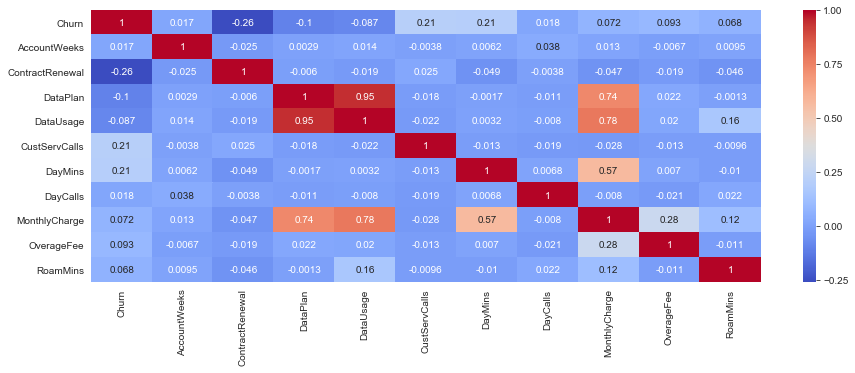

In [48]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.show()

- from the heatmap we can see that the dataplan and datausage are highly correlated and same goes for the monthly charges and the datausage.

In [51]:
df.corr()['Churn']

Churn              1.000000
AccountWeeks       0.016541
ContractRenewal   -0.259852
DataPlan          -0.102148
DataUsage         -0.087195
CustServCalls      0.208750
DayMins            0.205151
DayCalls           0.018459
MonthlyCharge      0.072313
OverageFee         0.092812
RoamMins           0.068235
Name: Churn, dtype: float64

- we can see that none of the features has the major affect on the churning since most of the features are having the less correlation coefficient.

### Model building

- lets start modelling with the stastical model first since there might be high collinearity btween the features which might affect the model accuracy,so if thers any after calculating the vif we can remove those features

- checking whether the train and test split proove that the sample belong to the population sample, we have to show the five point summary of the train and the test referring to the mean value of the features

In [91]:
#logistic regression
y=df['Churn']
x=df.drop('Churn',1)
x_const=sm.add_constant(x)
xtrain,xtest,ytrain,ytest=train_test_split(x_const,y,test_size=.3,random_state=100)

In [ ]:
train=pd.concat([xtrain,ytrain],1)
test=pd.concat([xtest,ytest],1)

In [92]:
model=sm.Logit(y,x_const).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.328436
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3331
Model:                          Logit   Df Residuals:                     3320
Method:                           MLE   Df Model:                           10
Date:                Tue, 21 Jan 2020   Pseudo R-squ.:                  0.2066
Time:                        11:50:36   Log-Likelihood:                -1094.0
converged:                       True   LL-Null:                       -1378.8
Covariance Type:            nonrobust   LLR p-value:                5.642e-116
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.9489      0.549    -10.843      0.000      -7.024      -4.874
AccountWeeks        0.0006      0.001      0.465      0.642      -0.002       0.003
ContractRenewal    -1.9847      0.144    -13.820      0.000      -2.266      -1.703
DataPlan           -1.1826      0.536     -2.205      0.027      -2.234      -0.131
DataUsage           0.3644      1.923      0.189      0.850      -3.405       4.133
CustServCalls       0.5079      0.039     13.032      0.000       0.431       0.584
DayMins             0.0175      0.032      0.538      0.591      -0.046       0.081
DayCalls            0.0036      0.003      1.326      0.185      -0.002       0.009
MonthlyCharge      -0.0277      0.191     -0.145      0.885      -0.402       0.346
OverageFee          0.1870      0.326      0.574      0.566      -0.451       0.825
RoamMins            0.0789      0.022      3.579      0.000       0.036       0.122
===================================================================================
"""

In [94]:
ypred=model.predict(xtrain)

In [95]:
predicted=ypred.apply(lambda x:0 if x<0.4 else 1)

In [98]:
print(confusion_matrix(ytrain,predicted))

[[  99 1880]
 [ 108  244]]


In [99]:
print(classification_report(ytrain,predicted))

              precision    recall  f1-score   support

           0       0.48      0.05      0.09      1979
           1       0.11      0.69      0.20       352

    accuracy                           0.15      2331
   macro avg       0.30      0.37      0.14      2331
weighted avg       0.42      0.15      0.11      2331



In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=x.columns).T

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
vif,1.003762,1.007223,12.463486,1963.50728,1.001949,1031.384848,1.002901,3241.999951,224.662802,1.346588


- we can see that the monthly charge is having the highest vif value and hence it needs to be removed

In [105]:
y=df['Churn']
x=df.drop(['Churn','MonthlyCharge'],1)
x_const=sm.add_constant(x)
xtrain,xtest,ytrain,ytest=train_test_split(x_const,y,test_size=.3,random_state=100)

In [106]:
model=sm.Logit(y,x_const).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.328439
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3331
Model:                          Logit   Df Residuals:                     3321
Method:                           MLE   Df Model:                            9
Date:                Tue, 21 Jan 2020   Pseudo R-squ.:                  0.2066
Time:                        12:03:27   Log-Likelihood:                -1094.0
converged:                       True   LL-Null:                       -1378.8
Covariance Type:            nonrobust   LLR p-value:                6.958e-117
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.9620      0.541    -11.016      0.000      -7.023      -4.901
AccountWeeks        0.0006      0.001      0.469      0.639      -0.002       0.003
ContractRenewal    -1.9853      0.144    -13.827      0.000      -2.267      -1.704
DataPlan           -1.1804      0.536     -2.202      0.028      -2.231      -0.130
DataUsage           0.0869      0.182      0.477      0.634      -0.270       0.444
CustServCalls       0.5078      0.039     13.033      0.000       0.431       0.584
DayMins             0.0128      0.001     11.892      0.000       0.011       0.015
DayCalls            0.0036      0.003      1.325      0.185      -0.002       0.009
OverageFee          0.1399      0.023      6.173      0.000       0.095       0.184
RoamMins            0.0790      0.022      3.583      0.000       0.036       0.122
===================================================================================
"""

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=x.columns).T

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,OverageFee,RoamMins
vif,1.00347,1.006525,12.459537,12.804016,1.001782,1.003346,1.002893,1.001649,1.346477


In [110]:
y=df['Churn']
x=df.drop(['Churn','MonthlyCharge','DataUsage'],1)
x_const=sm.add_constant(x)
xtrain,xtest,ytrain,ytest=train_test_split(x_const,y,test_size=.3,random_state=100)
model=sm.Logit(y,x_const).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.328473
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3331
Model:                          Logit   Df Residuals:                     3322
Method:                           MLE   Df Model:                            8
Date:                Tue, 21 Jan 2020   Pseudo R-squ.:                  0.2065
Time:                        12:11:12   Log-Likelihood:                -1094.1
converged:                       True   LL-Null:                       -1378.8
Covariance Type:            nonrobust   LLR p-value:                8.929e-118
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.9923      0.538    -11.145      0.000      -7.046      -4.938
AccountWeeks        0.0007      0.001      0.471      0.637      -0.002       0.003
ContractRenewal    -1.9872      0.144    -13.844      0.000      -2.269      -1.706
DataPlan           -0.9351      0.144     -6.487      0.000      -1.218      -0.653
CustServCalls       0.5070      0.039     13.028      0.000       0.431       0.583
DayMins             0.0128      0.001     11.894      0.000       0.011       0.015
DayCalls            0.0036      0.003      1.315      0.188      -0.002       0.009
OverageFee          0.1398      0.023      6.170      0.000       0.095       0.184
RoamMins            0.0831      0.020      4.090      0.000       0.043       0.123
===================================================================================
"""

In [111]:
vif = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=x.columns).T

,AccountWeeks,ContractRenewal,DataPlan,CustServCalls,DayMins,DayCalls,OverageFee,RoamMins
vif,1.002205,1.006153,1.000912,1.001663,1.002872,1.002865,1.001638,1.002986


- after removing the features with high multicollinearity we can see that the vif value is almost same for all the features

In [112]:
ypred=model.predict(xtrain)
pred=ypred.apply(lambda x:0 if x<0.4 else 1)

In [113]:
print(confusion_matrix(pred,ytrain))

[[1881  245]
 [  98  107]]


In [114]:
print(classification_report(pred,ytrain))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      2126
           1       0.30      0.52      0.38       205

    accuracy                           0.85      2331
   macro avg       0.63      0.70      0.65      2331
weighted avg       0.89      0.85      0.87      2331



### Lets build the Machine learning models since the stastical model is not providing promising results

In [140]:
from sklearn.preprocessing import StandardScaler as SS
ss=SS()
x_scaled=ss.fit_transform(x)

In [143]:
def model_compare(algo, xtrain, xtest, ytrain, ytest):
    algo.fit(xtrain, ytrain)
    y_pred_train = algo.predict(xtrain)
    y_prob_train = algo.predict_proba(xtrain)[:,1]
    
    y_pred_test = algo.predict(xtest)
    y_prob_test = algo.predict_proba(xtest)[:,1]
    
    print('Accuracy on Train set', accuracy_score(ytrain, y_pred_train))
    print('Accuracy on Test set', accuracy_score(ytest, y_pred_test))

    print('AUC on Train set', roc_auc_score(ytrain, y_prob_train))
    print('AUC on Test set', roc_auc_score(ytest, y_prob_test))
    
    fpr, tpr, thresholds = roc_curve(ytest, y_prob_test)
    
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, 'r-')
    plt.show()    

### LogisticRegression

In [142]:
y=df['Churn']
x=x_scaled
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=100)

In [157]:
lr=LogisticRegression()
lr.fit(xtrain,ytrain)
y_pred_train = lr.predict(xtrain)
y_pred_test = lr.predict(xtest)
print('Accuracy on Train set',accuracy_score(ytrain, y_pred_train))
print('Accuracy on Test set', accuracy_score(ytest, y_pred_test))

Accuracy on Train set 0.8588588588588588
Accuracy on Test set 0.868


Accuracy on Train set 0.8588588588588588
Accuracy on Test set 0.868
AUC on Train set 0.8158419082181082
AUC on Test set 0.8168729521517231


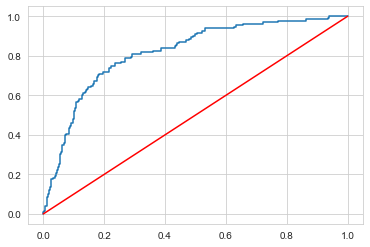

In [158]:
model_compare(lr,xtrain,xtest,ytrain,ytest)

### Decision Tree Classifier

Accuracy on Train set 1.0
Accuracy on Test set 0.902
AUC on Train set 1.0
AUC on Test set 0.8301636521754406


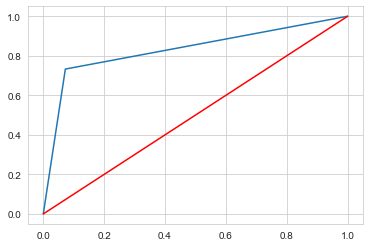

In [169]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(random_state=1)
model_compare(DT,xtrain,xtest,ytrain,ytest)

### hyperparameter tuning of Decision tree

In [167]:
from scipy.stats import randint as sp_randint
dt=DecisionTreeClassifier(random_state=1)
params={'criterion': ['gini', 'entropy'],
    'max_depth': sp_randint(2, 10),
    'min_samples_split': sp_randint(2,20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': sp_randint(2,15)}
rand_search_dt = RandomizedSearchCV(dt, param_distributions=params,
                                 cv=3, random_state=1)
rand_search_dt.fit(x,y)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=1,
             

Accuracy on Train set 0.9356499356499357
Accuracy on Test set 0.933
AUC on Train set 0.9144605000229683
AUC on Test set 0.9006096329026081


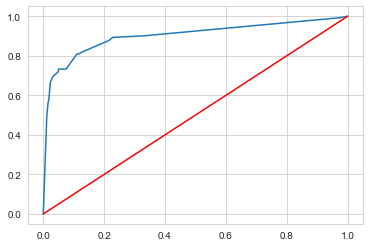

In [170]:
dt=DecisionTreeClassifier(**rand_search_dt.best_params_,random_state=1)
model_compare(dt,xtrain,xtest,ytrain,ytest)

- we can see that after tuning the hyperparameters the model is fitting really well when compared to the logistic regression

### Random Forest Classifier

Accuracy on Train set 1.0
Accuracy on Test set 0.935
AUC on Train set 1.0
AUC on Test set 0.914374687058038


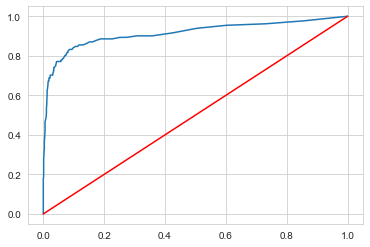

In [171]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=1)
model_compare(rf,xtrain,xtest,ytrain,ytest)

### Hyperparameter tuning of RandomForest Classifier

In [172]:
rfc = RandomForestClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,25),
    'criterion': ['gini', 'entropy'],
    'max_depth': sp_randint(2, 10),
    'min_samples_split': sp_randint(2,20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': sp_randint(2,15)}

rand_search_rfc = RandomizedSearchCV(rfc, param_distributions=params,
                                 cv=3, random_state=1)
rand_search_rfc.fit(x,y)
print(rand_search_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 22}


Accuracy on Train set 0.9506649506649507
Accuracy on Test set 0.936
AUC on Train set 0.9624544937755523
AUC on Test set 0.9271075817602052


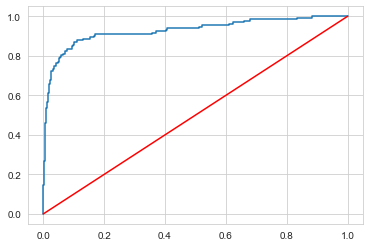

In [173]:
rfc=RandomForestClassifier(**rand_search_rfc.best_params_,random_state=1)
model_compare(rfc,xtrain,xtest,ytrain,ytest)

- we can see that the accuracy of the train set os improved but then the accuracy of the test set remains same even after tuning of the hyperparameters
- Decision tree was fitting well when compared to the random forest with an accuracy of 93%

#### lets try boosting the data so that we could get the better results

### Adaboost classifier

Accuracy on Train set 0.909051909051909
Accuracy on Test set 0.885
AUC on Train set 0.927910675731545
AUC on Test set 0.8727237589929636


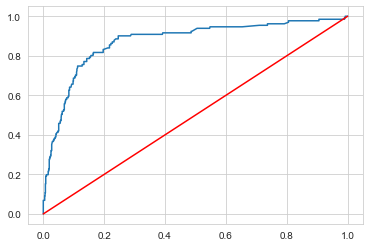

In [174]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
ada=AdaBoostClassifier(random_state=1)
ada.fit(xtrain,ytrain)
model_compare(ada,xtrain,xtest,ytrain,ytest)

### Gradient boosting classifier

Accuracy on Train set 0.9553839553839554
Accuracy on Test set 0.94
AUC on Train set 0.9621838968257614
AUC on Test set 0.9300547264118624


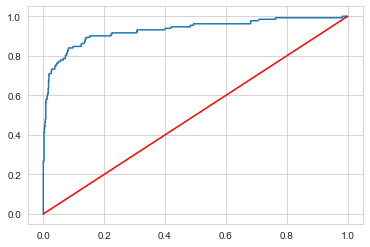

In [175]:
GB=GradientBoostingClassifier()
GB.fit(xtrain,ytrain)
model_compare(GB,xtrain,xtest,ytrain,ytest)

### Bagging Classifier

Accuracy on Train set 0.987987987987988
Accuracy on Test set 0.93
AUC on Train set 0.9996167141347788
AUC on Test set 0.8877537574996266


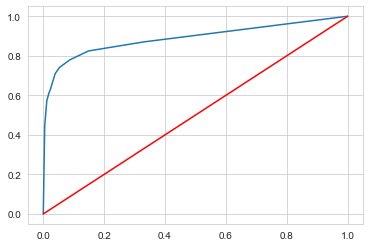

In [176]:
from sklearn.ensemble import BaggingClassifier
bc=BaggingClassifier(random_state=1)
model_compare(bc,xtrain,xtest,ytrain,ytest)

#### Lets use the sampling technique to balance the target variable 

In [178]:
from imblearn.over_sampling import SMOTE

In [180]:
smt = SMOTE()
xtrain,ytrain = smt.fit_sample(xtrain, ytrain)

### logistic Regression after sampling

Accuracy on Train set 0.7660434562910561
Accuracy on Test set 0.76
AUC on Train set 0.818717555045512
AUC on Test set 0.8219854355712892


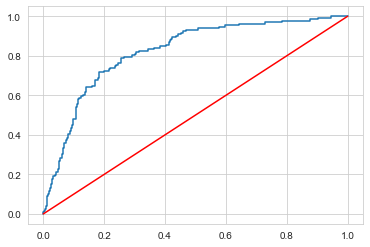

In [190]:
lr=LogisticRegression()
lr.fit(xtrain,ytrain)
model_compare(lr,xtrain,xtest,ytrain,ytest)

In [191]:
print(confusion_matrix(ytest,y_pred_test))

[[845  24]
 [108  23]]


In [192]:
print(classification_report(ytest,y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       869
           1       0.49      0.18      0.26       131

    accuracy                           0.87      1000
   macro avg       0.69      0.57      0.59      1000
weighted avg       0.83      0.87      0.84      1000



In [194]:
from sklearn.metrics import recall_score
recall_score(ytest,y_pred_test)

0.17557251908396945

- we can see that after oversampling the accuracy of the logistic model is decreased but then the precision is increased comparing with the older model

### Lets try sampling using Nearmiss

In [195]:
from imblearn.under_sampling import NearMiss
xtrain,xtest,ytrain,ytest=train_test_split()
nr=NearMiss()
xtrain, ytrain = nr.fit_sample(xtrain, ytrain)


NameError: name 'X_train' is not defined